# Introduction

/home/kokeeffe/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
(episode, score) = (50, 22.0)
(episode, score) = (100, 30.0)
(episode, score) = (150, 53.0)
(episode, score) = (200, 15.0)
(episode, score) = (250, 14.0)
(episode, score) = (300, 46.0)
(episode, score) = (350, 16.0)
(episode, score) = (400, 10.0)
(episode, score) = (450, 53.0)
(episode, score) = (500, 23.0)
(episode, score) = (550, 51.0)
(episode, score) = (600, 200.0)
(episode, score) = (650, 189.0)
(episode, score) = (700, 183.0)
(episode, score) = (750, 200.0)
(episode, score) = (800, 200.0)
(episode, score) = (850, 157.0)
(episode, score) = (900, 135.0)
(episode, score) = (950, 155.0)
(episode, score) = (1000, 169.0)


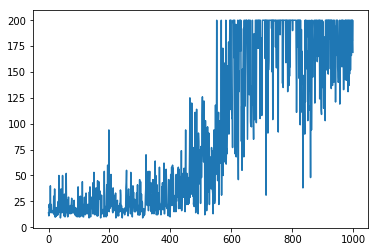

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gym
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
import keras.optimizers 
from keras import backend as K
from agent import Agent
%matplotlib inline


#Env
env = gym.make('CartPole-v0')
env.seed(1)  #for comparison
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n

#Agent
input_dim, output_dim = num_states, num_actions
lr, gamma, tau, clipnorm, verbose = 0.001, 0.99, 0.01, True, False
agent = Agent(input_dim, output_dim, lr, gamma, tau, clipnorm, verbose)

#Train
EPISODES = 1000
scores = []
for e in range(1,EPISODES+1):
    state = env.reset()
    state = np.reshape(state, [1, num_states])
    reward_sum = 0
    done = False
    while not done:
        # env.render()
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward_sum += reward
        next_state = np.reshape(next_state, [1, num_states])
        agent.remember(state[0], action, reward, next_state[0], done)
        state = next_state
    agent.learn()
    scores.append(reward_sum)
    if e % 50 == 0:
        print '(episode, score) = ' + str((e,reward_sum))
plt.plot(scores)

### Roughwork

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gym
from collections import deque
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam 
from keras.optimizers import RMSprop
from keras import backend as K
from keras.utils import to_categorical
from keras.layers import Dense, Input, concatenate


class Critic:
    
    """ Critic for A2C  """
    
    def __init__(self,input_dim, output_dim,lr,gamma,tau, clipnorm, verbose = False):
        
        #Pars
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr  #learning rate for optimizer
        self.gamma = gamma
        self.tau = tau
        self.verbose = verbose
        self.clipnorm = clipnorm
        
        #Make models
        self.model = self._make_network()
        self.target_model = self._make_network()                       
        self.target_model.set_weights(self.model.get_weights()) 
        
        #optimizer
        self.opt = self.optimizer1()
        
        
    def learn(self,S,R,D,V1):
        self.opt([S,R,D,V1])
    
    #def learn(self,S,adv):
    #    self.opt([S,adv])

    
        
    def _make_network(self):        
        S = Input(shape=(self.input_dim,))
        x = Dense(128, activation = 'relu')(S)
        out = Dense(1, activation = 'linear')(x)
        model = Model(inputs = S, outputs = out)
        model.compile(loss = 'mse', optimizer = Adam( lr = self.lr, clipnorm = self.clipnorm))
        return model
    
       
    def optimizer(self):
        """ The critic loss: L_i = \sum_{batch}  ( V_i - G_i )^2 
        
            where G_i is the discounted reward.
        
        """
        
        #Placeholders
        discounted_returns_placeholder = K.placeholder(name='discounted_return',shape=(None,))        
        critic_loss = K.mean(K.square(discounted_returns_placeholder - self.model.output))
        
        #Define optimizer
        adam_critic = RMSprop(lr = self.lr, epsilon = 0.1, rho = 0.99)  #arbitray
        pars = self.model.trainable_weights
        updates = adam_critic.get_updates(params=pars,loss=critic_loss)
        
        return K.function([self.model.input, discounted_returns_placeholder], [], updates=updates)        
        
 
    def optimizer1(self):
        
        """ 
            The loss function for the critic is
           
            L_i = \sum_{batch}  ( V_i - y_i )^2 
            
            where,
            
            y_i = r_i + (1-done) gamma* V_i(s)  for non-terminal \vec{x'}
            r_i = reward to agent i
            gamma = discount factor
            done = 1 if episode finished, 0 otherwise
        """
        
        #Placeholders
        S_pl = self.model.input
        R_pl = K.placeholder(name='reward',shape=(None,))
        D_pl = K.placeholder(name='done', shape=(None,))
        V1_pl = K.placeholder(name='V1',shape=(None,))

        #Find yi
        Y = R_pl + (1-D_pl)*self.gamma*V1_pl
        #Y = R_pl + (1-D_pl)*self.gamma*K.reshape(V1_pl,(1,len(V1_pl)))
        
        #Find loss
        loss = K.mean(K.square(self.model.output - Y))
        
        #Define optimizer
        adam_critic = RMSprop(lr = self.lr, epsilon = 0.1, rho = 0.99)  #arbitray
        pars = self.model.trainable_weights
        updates = adam_critic.get_updates(params=pars,loss=loss)
        
        return K.function([S_pl, R_pl, D_pl ,V1_pl], [], updates=updates)  

critic = Critic(input_dim, output_dim,lr,gamma,tau, clipnorm, verbose = False)
S,A,R,S1,D = agent.get_batch()
V1 = critic.model.predict(S1)
critic.learn(S,R,D,V1)

### Grab batches

In [36]:
agent = Agent(input_dim, output_dim, lr, gamma, tau, clipnorm, verbose)
state = env.reset()
state = np.reshape(state, [1, num_states])
reward_sum = 0
done = False
while not done:
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    reward_sum += reward
    next_state = np.reshape(next_state, [1, num_states])
    agent.remember(state[0], action, reward, next_state[0], done)
    state = next_state 

In [42]:
V1 = agent.critic.model.predict(S)

In [44]:
V1.shape

(22, 1)

In [49]:
K.flatten(V1)

<tf.Tensor 'Reshape_2:0' shape=(22,) dtype=float32>